# Extracting the Tangible Assets, and the year they relate to

## Method Overview


1.  Identify keywords matching a statistic we wish to extract (eg;  "Tangible" for tangible assets).  Ideally this matching process will be able to deal with row labels that spread over two lines.
2.  Extract from that line any numbers that are greater than 50 (crude filter for notes reference numbers).
3.  Separately extract years and their ordering, by looking for two year numbers in line with one year's difference and the older year on the right.  This is probably easier with this sparse table structure.

From UK National Accounts - A Short Guide:

"The national ccounts identifiy two types of asset within the economy. The first of
these is non-financial assets and includes fixed assets (buildings, vehicles,
machinery), valuables, inventories and non-produced assets (such as land). The
second type is financial assets. These include currency holdings, bank deposits,
ownership of shares and loans (from the point of view of the lender). Every financial
asset has an equal and opposite liability – in the examples above, the central bank is
liable for currency, the bank where the deposits are held, the share issuer and, in the
case of a loan, the borrower. "

In [7]:
import numpy as np
import pandas as pd
import sys
import os
import pytesseract                            # API for letting python interface with Google's tesseract OCR software

import importlib

import xbrl_image_parser as xip


# -----------------------------------------------------------------
import re
import cv2                                    # Open Computer Vision library
import PyPDF2                                 # All things PDF format related
import io                                     # Something about messing with memory
from wand.image import Image                  # For messing with images
from PIL import Image as Im                   # Likewise images
import codecs                                 # Unknown

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.path import Path
from matplotlib.patches import PathPatch

from imageio import imread  # Lets me put an image into a plot

In [8]:
# Get a list of all of the pdf files in the directory "CH_records"
files = [filename.split(".")[0] for filename in os.listdir("./working/ocr_output_compiled") if ".csv" in filename]

In [9]:
for each in range(len(files)):
    print(each, files[each])

0 00002404
1 868273
2 1983517
3 2765595
4 03293902
5 02959325
6 00542515
7 01539777
8 02714555
9 00030177
10 04802747
11 02266230
12 00983951
13 01002610
14 01804186
15 5508774
16 02430955
17 00053475
18 02245999
19 00553535
20 3387163
21 01337451
22 3459907
23 00178090
24 00468115
25 01369166
26 00782931
27 09457025
28 983951
29 01370175
30 06005142
31 04860660
32 2303730
33 02582534
34 00477955
35 04558828
36 06034603
37 3824626


In [10]:
# Rediscovering what works...
importlib.reload(xip)
index=0

# So far can create all those extra geometric features, can convert to numeric
test = pd.read_csv("./working/ocr_output_compiled/"+files[index]+".csv")
line_test = xip.make_measurements(test)
line_test['numerical'] = xip.convert_to_numeric(line_test['text'])

# Drop all weird page-marking lines and such which have no text
line_test = line_test[line_test['conf'] != -1]

In [18]:
importlib.reload(xip)
#os.system("firefox " + "./example_data_PDF/" + files[index] + ".pdf" + " &")

agg_text = xip.aggregate_sentences_over_lines(line_test)
agg_text[agg_text['text'].apply(len) > 4]

,block_num,bottom,csv_num,left,line_num,par_num,right,text,top
1,1.0,146.0,1.0,83.0,2.0,1.0,155.0,<f4- e a. t,92.0
4,2.0,613.0,1.0,524.0,1.0,1.0,1568.0,Financial Statements,525.0
5,2.0,789.0,1.0,92.0,1.0,2.0,2141.0,\ Southampton Isle of Wight and,670.0
6,2.0,934.0,1.0,525.0,2.0,2.0,2010.0,South of England Royal Mail,815.0
7,2.0,1078.0,1.0,526.0,3.0,2.0,2167.0,Steam Packet Company Limited,961.0
8,3.0,1412.0,1.0,524.0,1.0,1.0,1392.0,For the Year Ended 31 December 2015,1377.0
14,9.0,3076.0,1.0,1962.0,1.0,1.0,2153.0,*“ASF716WA*,3048.0
15,10.0,3125.0,1.0,1782.0,1.0,1.0,2344.0,A08 09/09/2016 . #102,3094.0
16,10.0,3170.0,1.0,1899.0,2.0,1.0,2218.0,COMPANIES HOUSE,3141.0
17,11.0,3301.0,1.0,1583.0,1.0,1.0,2268.0,Registered number: 00002404,3242.0


In [32]:
agg_text['second_line'] = agg_text['text'].apply(lambda x: np.where(re.search("^[a-z].*", x.strip()), True, False))

agg_text

,csv_num,block_num,par_num,line_num,text,top,bottom,left,right,second_line
0,1,1,1,1,"r,",106,167,72,93,True
1,1,1,1,2,<f4-,92,170,83,122,False
2,1,1,2,1,e a.,63,169,112,132,True
3,1,1,2,2,t,139,146,141,155,True
4,1,2,1,1,Financial Statements,525,613,524,1568,False
5,1,2,2,1,\ Southampton Isle of Wight and,670,789,92,2141,False
6,1,2,2,2,South of England Royal Mail,815,934,525,2010,False
7,1,2,2,3,Steam Packet Company Limited,961,1078,526,2167,False
8,1,3,1,1,For the Year Ended 31 December 2015,1377,1412,524,1392,False
9,1,4,1,1,,2870,3043,1988,1996,False


### Next Challenge
For a balance sheet item where the description runs over two lines, the numbers of interest align to the second line.  Need to improve my schema to detect that...

In [129]:
importlib.reload(xip)
element_row = xip.find_element_location(line_test, "Creditors: amounts falling due after")
element_row

,Unnamed: 0,level,page_num,block_num,par_num,line_num,word_num,left,top,width,...,area,space_from_left,line_word_count,line_index,doc_spacing_mean,doc_spacing_median,doc_spacing_sd,numerical,keyword_found,text_agg
10825,75,5,1,8,1,2,1,314,1877,117,...,2574,NaN,10,3146,22.759327,14.0,87.833959,NaN,False,Creditors: amounts falling due after more than...


In [130]:
values = xip.extract_parallel_numbers(line_test, element_row)

In [131]:
values

,Unnamed: 0,level,page_num,block_num,par_num,line_num,word_num,left,top,width,...,bottom,area,space_from_left,line_word_count,line_index,doc_spacing_mean,doc_spacing_median,doc_spacing_sd,numerical,keyword_found
14149,252,5,1,29,1,1,1,2211,1875,83,...,1904,2407,NaN,2,3241,22.759327,14.0,87.833959,3071.0,False


In [37]:
q_func = lambda x: str(x).replace(",", "").strip("(").strip(")")

pd.to_numeric( test['text'].apply(q_func) , errors="coerce")

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13         NaN
14         NaN
15         NaN
16         NaN
17         NaN
18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
23         NaN
24         NaN
25         NaN
26         NaN
27         NaN
28         NaN
29         NaN
         ...  
14491      NaN
14492      NaN
14493      NaN
14494      NaN
14495      NaN
14496      NaN
14497      NaN
14498      NaN
14499      NaN
14500      NaN
14501      NaN
14502      NaN
14503      NaN
14504      NaN
14505      NaN
14506      NaN
14507      NaN
14508      NaN
14509      NaN
14510      NaN
14511      NaN
14512      NaN
14513      NaN
14514    102.0
14515      NaN
14516      NaN
14517      NaN
14518      NaN
14519     38.0
14520      NaN
Name: text, Length: 14521, dtype: float64

### Quick test of extraction algorithm so far

In [9]:
records = []
for i in range(len(files)):
    try:
        records.append(fire_system(i))
    except Exception as e:
        records.append("FAILED - "+str(e)+files[i])

In [96]:
records

[['00002404', ('£000', 81), (2015.0, 18195.0, 96), (2014.0, 20732.0, 96)],
 ['868273', ('£000', 80), (2015.0, 177198.0, 96), (2014.0, 185204.0, 96)],
 ['1983517', ('£', 41), (2017.0, 11334227.0, 92), (2016.0, 15370959.0, 96)],
 ['2765595', ('£', 65), (2015.0, 17200960.0, 94), (2014.0, 18546119.0, 94)],
 ['03293902',
  ('£', 49),
  (2015.0, 'N/A', 'N/A'),
  (2014.0, 'N/A', 'N/A'),
  KeyError('left')],
 ['02959325', ('£', 57), (2016.0, 786.0, 0)],
 ['00542515', ('$', 101), (2015.0, 567.0, 96)],
 ['01539777', ('£', 36), (2016.0, 6523212.0, 50), (2015.0, 7521372.0, 81)],
 ['02714555', ('£7000', 25), (2015.0, 39360.0, 95), (2014.0, 44984.0, 96)],
 ['00030177', ('£000', 32), (2016.0, 706.0, 96), (2015.0, 12880.0, 96)],
 'FAILED - zip argument #1 must support iteration04802747',
 ['02266230',
  ('£', 43),
  (2015.0, 'N/A', 'N/A'),
  (2014.0, 'N/A', 'N/A'),
  KeyError('left')],
 ['00983951', ('£000', 75), (2016.0, 57808.0, 95), (2015.0, 54409.0, 96)],
 ['01002610', ('£000', 49), (2015.0, 49634

### List of failed records from datasets and their reasons for failing

00542515 - Reporting values are actually in $million for BP :S

04802747 - No "tangible assets" listed

5508774 - No "tangible assets" listed - DOES list "Property, plant and equipment".

00053475 - Tangible assets listed, POSSIBLE failure, has formatted dates rather than just year number ("2.7.16")

00553535 - Tangible assets listed but are numbers < 50, and unit is "£m".  Will be filtered and would be wrong anyway!

01337451 - No "tangible assets" listed

00468115 - Tangible assets listed, only obvious cause of failure, word "Tangible" a bit damaged in the scan

06005142 - No "tangible assets" listed

04558828 - No "tangible assets" listed


### Implications for project development

Getting metadata on the units of the numbers we're using is essential.  That's probably a "silent error" in a lot of these.  Looking for elements with "£" or "\$", collecting all and reporting max count as reporting unit.  Error is BP record, where unit is "$ million".  The problem is the space, it's ruining detection this may be a problem for a few other records in £'s.  Lesser problem;  "£'000" being read as "£7000" or w. degree sign in place of apostrophe.  This is systematic and repeatable so easily solved.  Can't see an elegant solution for this one.

Getting non-year style column date headings would also be good but may be less essential.  The document still has frequent mentions of its two principal years, they just don't appear in order.  Maybe do a raw count of suitable year mentions and pick the two most common rather than all that shifting nonsense?


Finally, fault-tolerant search for word search for "tangible", fuzzy match algorithm with hefty penalties for extra characters (to rule out "Intangible", for example) would do the trick.


### Quick update

New method for getting years (look for most common year numbers, forget about the "shifting" nonsense) appears to work.

New method for getting units has two failures;  1)  On one where the units are "£m" meaning "million", 2) where £'000 is being miss-read as £7000.  Since the method is basically robust (it finds the correct unit) I just
need to think on how to process it into a multiplier once received.  count zeros, exceptions for k/K (thousand)
and m/M (million)?


### Current hit-list

Get agg levels function up and running, matching multi-line entries

Create a fuzzy-matcher to replace precise word-matching & implement in all functions


# PLOTTING DIAGNOSTICS - Finding out if the blocking algorithm is truly unreliable

In [84]:
# Figure out the ratio of whitespace in each block

def calculate_whitespace(data, threshold=0.8):
    
    # to hold calculated values
    whitespace = []
    block_num = []
    csv_num = []
    whitespace_frac = []
    whitespace_anomalous = []

    for csv in data['csv_num'].unique():
        for block in data[data['csv_num']==csv]['block_num'].unique():
            
            subset = data[(data['csv_num']==csv) & (data['block_num']==block)]      # Get the relevant data
            total_area = subset[subset['par_num']==0]['area'].sum()                 # Total area of block
            word_area = subset[subset['word_num'] > 0]['area'].sum()                # Total area occupied by words (assume rectangles)
            whitespace.append(total_area - word_area)                               # Therefore total area whitespace
            csv_num.append(csv)
            block_num.append(block)
            fraction = total_area - word_area / total_area                     # Finally, fraction whitespace
            whitespace_frac.append(fraction)   
            
            # Decide if it's anomalous or not following threshold (between 0 and 0.99)
            whitespace_anomalous.append((fraction > threshold) & (fraction < 0.99 ))
            
    whitespace_data = pd.DataFrame({"whitespace":whitespace,
                                    "whitespace_frac":whitespace_frac,
                                    "whitespace_anomalous":whitespace_anomalous,
                                    "block_num":block_num,
                                    "csv_num":csv_num})
    
    return( data.merge(whitespace_data, on=["csv_num", "block_num"], how="left") )

In [85]:
# Plotting commands

def create_path_patches(line_data, csv_num):
    
    line_data=line_data[line_data['csv_num']==csv_num].reset_index()
    
    # For storing all of the created pathpatches
    path_patches = []

    # Need the height and width of the image to create the canvas
    image_length = line_data.loc[0]['height']
    image_width = line_data.loc[0]['width']

    #sample = line_data[line_data['line_num'] == 0]
    sample = line_data
    sample = sample.drop(0)
    # Iterate through the samples
    for index, row in sample.iterrows():
    
        # Define the shape by specifying its corners, remember
        # x-y coords start at BOTTOM LEFT of image
        vertices = [(row['left'], row['top']),      # Top left
                     (row['left'], row['bottom']),   # Bottom left
                     (row['right'], row['bottom']),  # Bottom right
                     (row['right'], row['top']),     # Top right
                     (0, 0)]                                        # Blank for closing off the polygon automatically
        # Codify instructions to path tracer for 
        codes = [Path.MOVETO] + [Path.LINETO]*3 + [Path.CLOSEPOLY]
    
        # Face colour, based on whether the whitespace is anomalous
        face_colour = str(np.where(row['whitespace_anomalous']==True, "red", "green"))
    
        # Line colour, based on whether the word spacing is anomalous
        #line_colour = str(np.where(row['word_spacing_anomalous']==True, "red", "green"))

        # Convert gathered information to a path
        path_patches.append( {"path":Path(vertices, codes),
                              "face_colour":face_colour,
                              "line_colour": "green"} )
    
    return(path_patches, vertices)

In [86]:
def plot_doc(path_patches, vertices, filepath):

    # Plot the lot!
    fig, ax = plt.subplots(figsize=(270, 100))
    for each in path_patches:
        ax.add_patch(PathPatch(each['path'],
                               facecolor = each['face_colour'],
                               edgecolor=each['line_colour'],
                               lw=3,
                               alpha=0.3))
    
    ax.set_title("Discovered blocks")

    ax.dataLim.update_from_data_xy(vertices)
    ax.autoscale_view()

    plt.imshow(imread(filepath), cmap="gray")
    plt.savefig("./output_graphical/discovered_blocks.png")
    plt.show()

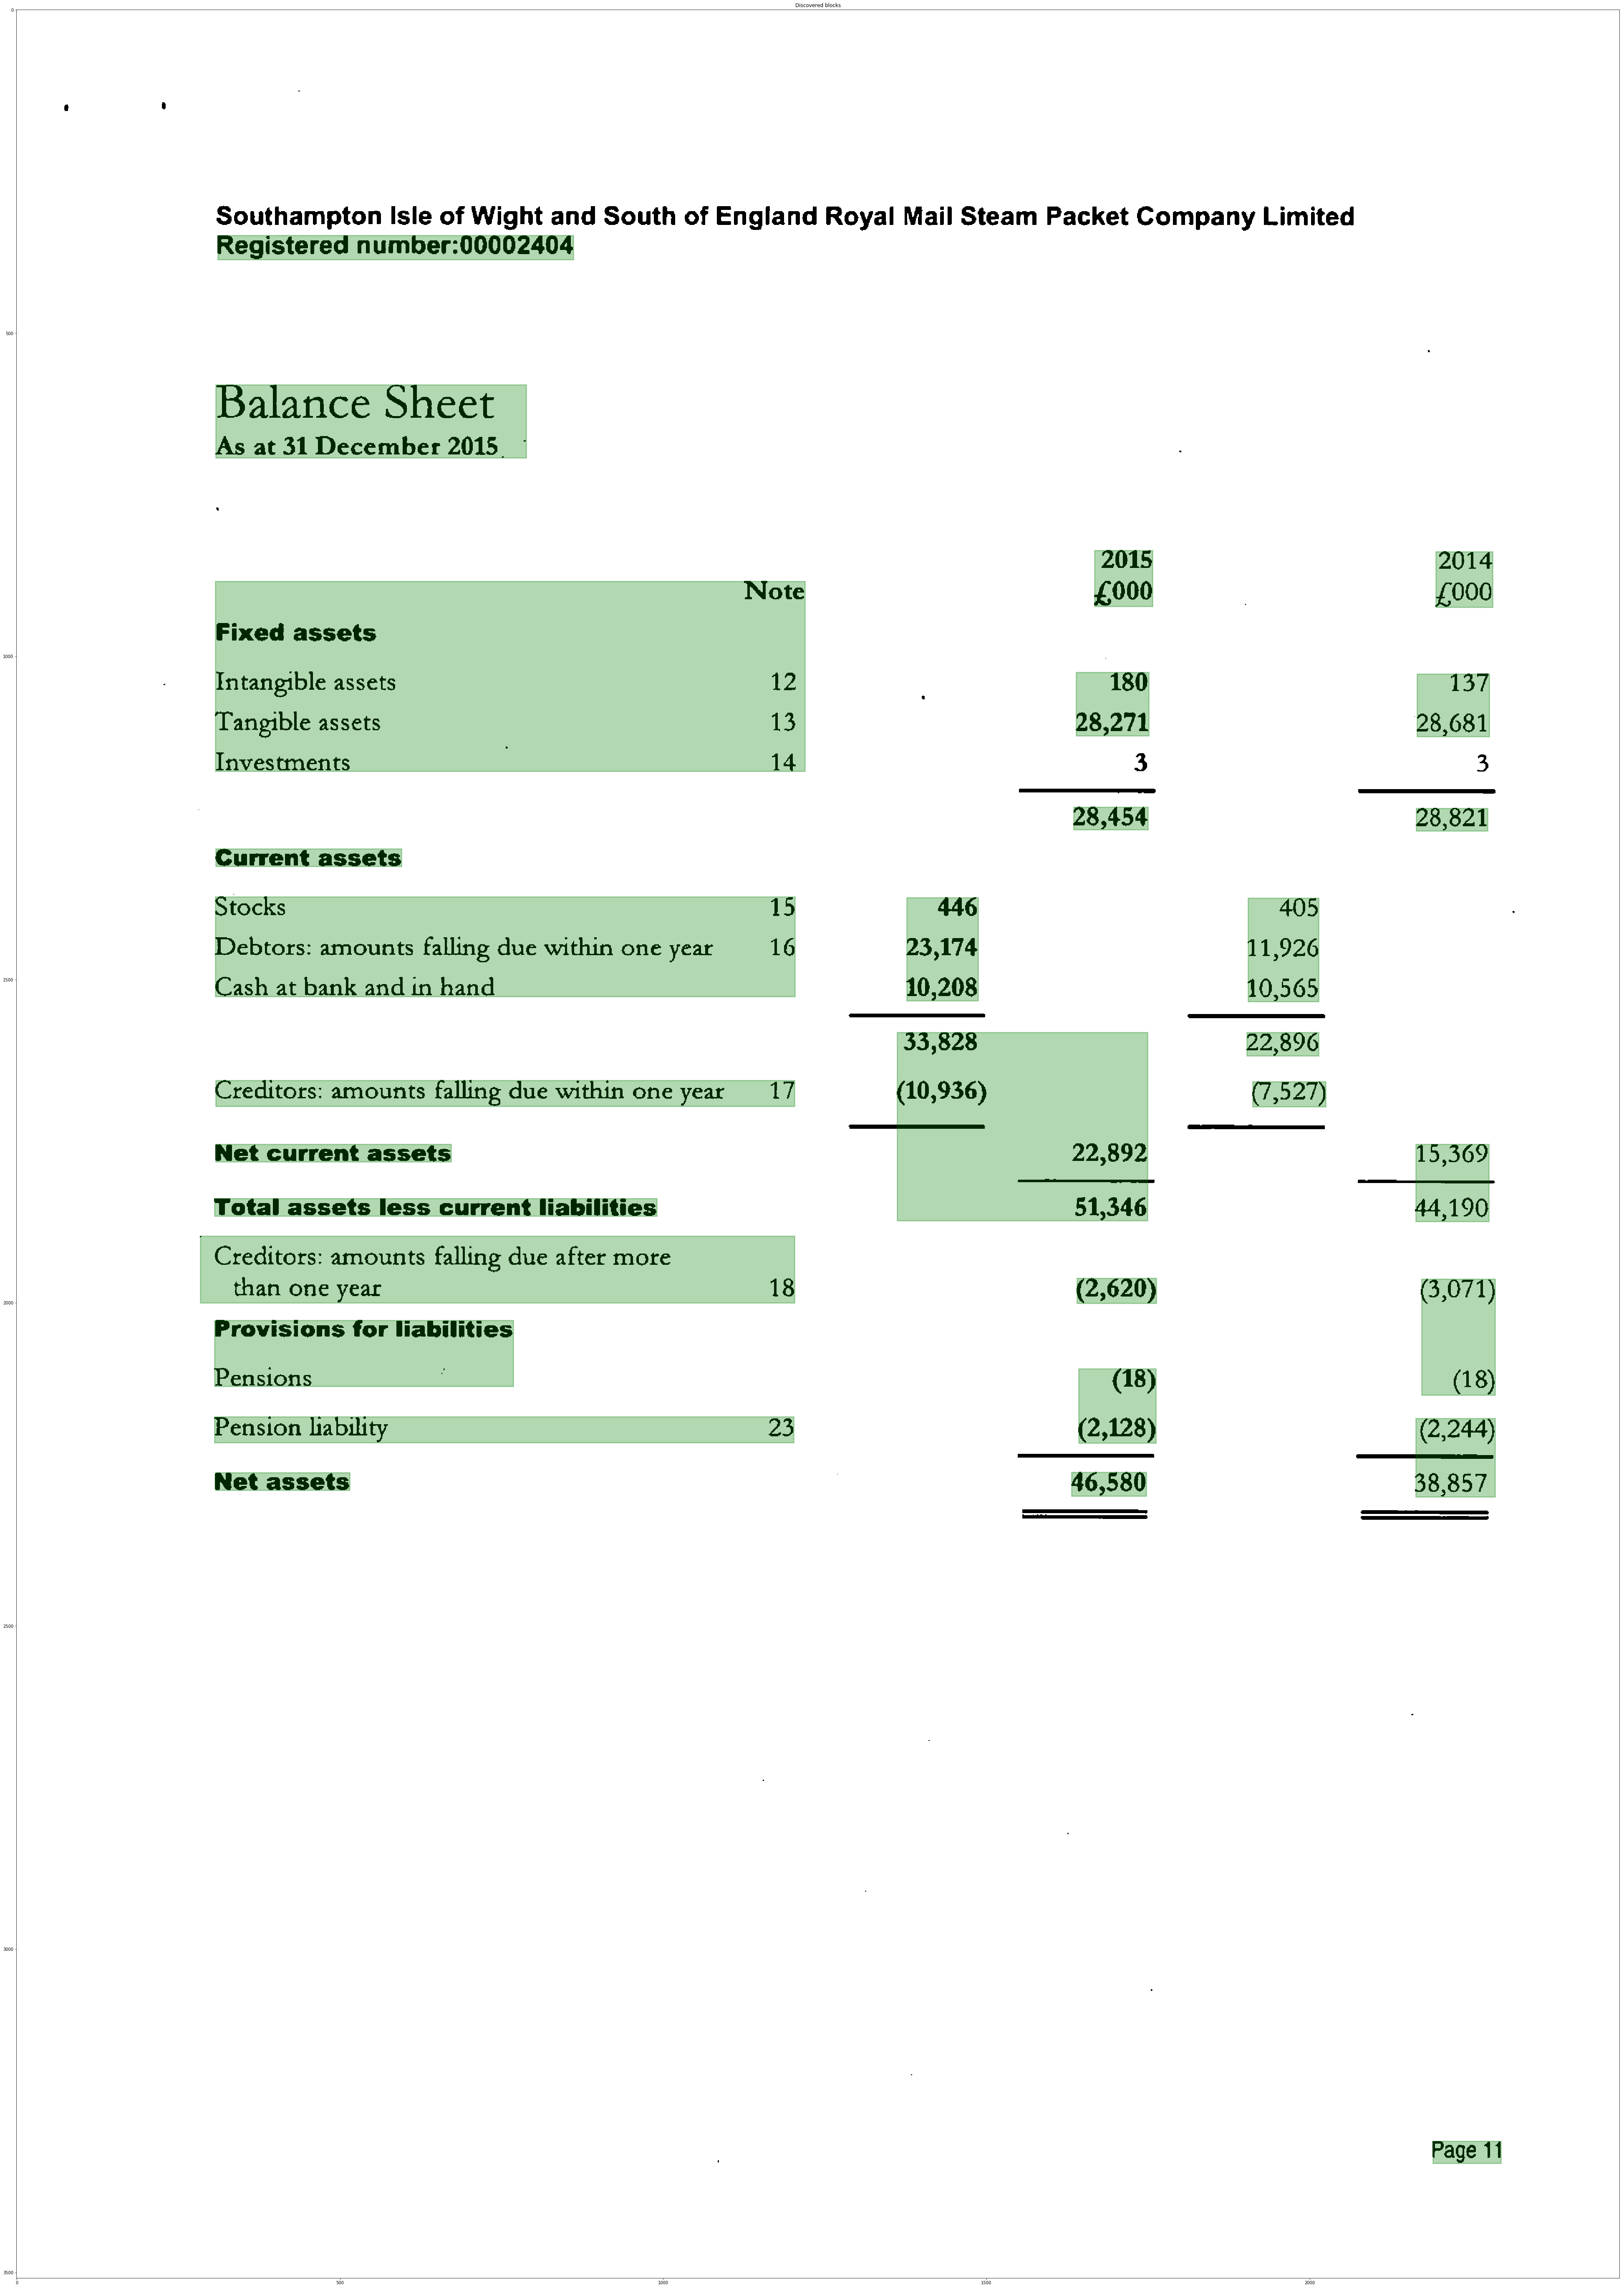

In [89]:
# Pick the file and page to plot
csv_num=14
file_index=0

# Pick the block level to portray
level=3

# Do all the maths
white_test=calculate_whitespace(xip.make_measurements(pd.read_csv("./working/ocr_output_compiled/"+files[file_index]+".csv")))

# Define the boxes to plot
path_patches, vertices = create_path_patches(white_test[white_test['level']==level], csv_num=csv_num)

# Draw everything up for inspection
plot_doc(path_patches, vertices, "./working/preprocessed/"+files[file_index]+"-"+str(csv_num)+".png")

In [ ]:

# Retrieve the most common pair of years found on any line
def retrieve_year_values(data):
    data = data[['keyword_index', 'left', 'numerical']].sort_values(by=['keyword_index', 'left'], ascending=[True, True])
    
    # Get the index and value of the next entry along
    data['keyword_index_shift'] = data['keyword_index'].shift(-1)
    data['numerical_shift'] = data['numerical'].shift(-1)
    
    # Test if valid year pair (will give value of 1 for a pair of years in
    # the right order on the same line)
    data['valid_year_pair'] = (data['keyword_index']==data['keyword_index_shift']) *\
                              (data['numerical'] - data['numerical_shift'])
    
    # Aggregate count by pair values
    year_pairs = data[data['valid_year_pair']==True][['numerical', 'numerical_shift', 'valid_year_pair']].\
                         groupby(['numerical', 'numerical_shift']).\
                         count()
    
    # Return most common pair
    return(year_pairs['valid_year_pair'].idxmax())



# Find the years to which the tables apply
def determine_years(subset, limits=[2000, 2050]):

    # 2. Find examples in the value range of interest
    subset['keyword_found'] = (subset['numerical'] >= limits[0]) & (subset['numerical'] <= limits[1])
    
    elements = pd.DataFrame()
    
    for index, row in subset[subset['keyword_found']==True].iterrows():
        
        selection = subset[(subset['top'] < row['bottom']) &         # Subset to elements roughly in line with keyword
                           (subset['bottom'] > row['top']) &         # Remembering w. vertical position 0 is at top
                           (subset['csv_num'] == row['csv_num']) &   # Make sure we're (literally) on the same page
                           (subset['numerical'] > limits[0]) &       # Filter out all of these NaN's and note references
                           (subset['numerical'] < limits[1])]
        
        selection['keyword_index'] = index
        
        elements = elements.append(selection)
    
    elements = elements.drop_duplicates(subset=["top", "left"])
    
    return(retrieve_year_values(elements))


# Find a statistic in the discovered tables...
def extract_stat_old(subset, keyword):

    # Find examples of the keyword of interest
    subset['keyword_found'] = subset['text']==keyword
    
    elements = pd.DataFrame()
    
    # For each keyword, hunt down all numerical values roughly horizontally
    # aligned with it
    for index, row in subset[subset['keyword_found']==True].iterrows():
        
        selection = subset[(subset['top'] < row['bottom']) &         # Subset to elements roughly in line with keyword
                           (subset['bottom'] > row['top']) &         # Remembering w. vertical position 0 is at top
                           (subset['csv_num'] == row['csv_num']) &   # Make sure we're (literally) on the same page
                           (subset['left'] > row['left']) &          # Make sure the numbers are to the right of the row label
                           (subset['numerical'] > 50)]               # Filter out all of these NaN's and note references
        
        # Assign an index to the search results matching
        # the line index of the original keyword
        selection['keyword_index'] = index
        
        elements = elements.append(selection)
    
    # Return the identified values, and how confident Tesseract is in its reading
    return(tuple(elements['numerical']),
           tuple(elements['conf']))


def get_numbers_from_results(subset):
    
    elements = pd.DataFrame()
    
    # For each keyword, hunt down all numerical values roughly horizontally
    # aligned with it
    for index, row in subset.iterrows():
        
        selection = subset[(subset['top'] < row['bottom']) &         # Subset to elements roughly in line with keyword
                           (subset['bottom'] > row['top']) &         # Remembering w. vertical position 0 is at top
                           (subset['csv_num'] == row['csv_num']) &   # Make sure we're (literally) on the same page
                           (subset['left'] > row['left']) &          # Make sure the numbers are to the right of the row label
                           (pd.isna(subset['numerical'])==False)]
    
        # Assign an index to the search results matching
        # the line index of the original keyword
        selection['keyword_index'] = index
        
        elements = elements.append(selection)
    
    elements = elements.sort_values("left", ascending=False).iloc[0:2,]
    
    return(elements)


# Aggregate up, then concatenate sequential blocks to create
# tuples, essentially.  Return concatenated text, block dimensions
# and id variables for the first of the two blocks
def agg_level_concat(dat, level):
    
    dat = dat[dat['level']>=level] #[['csv_num', 'block_num', 'par_num', 'line_num', 'text']]
    
    # Not certain the "nan" value stripper below will work as expected
    mat = dat.groupby(["csv_num", "block_num", "par_num", "line_num"])['text'].\
               apply(lambda x: " ".join([str(e) for e in list(x)]).strip("nan ")).\
               reset_index()
    
    test = dat.groupby(["csv_num", "block_num", "par_num", "line_num"])['bottom'].max().reset_index()
    
    # concatenate sequentials (tupleize)
    mat['text_agg'] = mat['text'] + " " + mat['text'].shift(-1)
    
    return(test)


def extract_stat_advanced(data, keyword):
    """ TWO upgrades to make to this function.  It has
    to be able to deal with fuzzy matching (problem, 
    tangible vs intangible, heavily penalise extra characters?)
    and it has to be able to deal with finding stats using
    the output of agg_level_concat(). """
    
    elements = get_numbers_from_results(data[data['text'] == keyword])
    
    if len(elements) < 1:
        
        data_agg = agg_level_concat(data, level=4)
        
        data_agg_subset = data_agg[data_agg['text_agg'] == keyword]
        
        lines_of_interest = pd.DataFrame()
        
        for index, row in data_agg_subset.iterrows():
            
            lines_of_interest.append(data[(data['csv_num'] == row['csv_num']) &
                                          (data['block_num'] == row['block_num']) &
                                          (data['par_num'] == row['par_num']) &
                                          (data['line_num'] == row['line_num'])] )
        
        
    
    
    
    # Take only the two left-most values
    return(tuple(elements['numerical']),
           tuple(elements['conf']))